## Setting Up

In [1]:
# Turn on inline display of plots in the notebook. (We should work on a more
# portable solution such as saving th plots to files down the road.)
%matplotlib inline

In [2]:
import pyodbc

#### Create a connection function

In [3]:
# Connect via Windows authentication:
# conn_specs = ('DRIVER={ODBC Driver 17 for SQL Server};'
#                                     + 'SERVER=scotty-test;'
#                                     + 'DATABASE=Interject_Reporting;'
#                                    + 'trusted_connection=yes;')
# conn_str = 'mssql+pyodbc:///?odbc_connect={}'.format(conn_specs)
# engine = sqla.create_engine(conn_str)

# Define a function that we can use to connect to a db on the fly:
def pyodbc_connect_scotty_test(db_name):
    try:
        connection = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};'
                                        + 'SERVER=scotty-test;'
                                        + 'DATABASE=' + db_name + ';'
                                       + 'trusted_connection=yes;') # Windows auth
        return connection
    except:
        return 1 # could not connect

In [4]:
import pandas as pd

## Visualizing [DataCells].[DurationSeconds]

In [17]:
# Connect to [Interject_Reporting]:
# intj_reporting_df = pd.read_sql('[DataCells].[Request]', engine)

reporting_conn = pyodbc_connect_scotty_test('Interject_Reporting')

In [18]:
# Create a cursor to run straight SQL queries:
# reporting_cursor = reporting_conn.cursor()

In [19]:
# Load [DataCells].[Request] and [DataCells].[Request_History] into DataFrames:
request = 'SELECT * FROM [DataCells].[Request]'  # Don't need * here...
request_history = 'SELECT * FROM [DataCells].[Request_History]'
request_df = pd.read_sql(request, reporting_conn) # So we don't need SQLalchemy...
request_history_df = pd.read_sql(request_history, reporting_conn) # So we don't need SQLalchemy...

[DataCells].[DurationSeconds] includes negative values for some reason... their absolute values are accurate, but just have a - in front of them...

In [7]:
request_df['DurationSeconds'].describe()

count    281.000000
mean       5.039146
std       60.829051
min      -10.000000
25%       -2.000000
50%       -1.000000
75%        0.000000
max      984.000000
Name: DurationSeconds, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x094EB9D0>]],
      dtype=object)

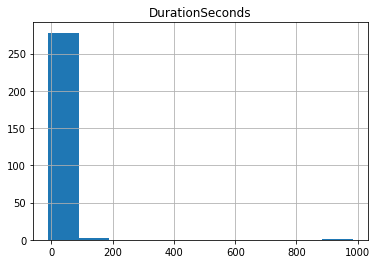

In [20]:
# Histogram of DurationSeconds:
request_df.hist(column='DurationSeconds')

## Visualizing request time durations manually (StartTimeStamp - EndTimeStamp)

Create a pd series that is ( StartTimeStamp - EndTimeStamp ). Doing this to resolve the negative DurationSeconds values reported above...

#### Setting Up

In [21]:
# Define a function that we can use with both [DataCells].[Request] and .[Request_History]
def get_request_time_durations(table_name):
    start_end_diff = 'SELECT datediff(second, [StartTimeStamp], [EndTimeStamp]) as StartEndDiffSeconds FROM [DataCells].[' + table_name + ']'
    return( pd.read_sql(start_end_diff, reporting_conn) )

    # # Do it with a cursor:
    # reporting_cursor.execute(start_end_diff_sql)
    # request_durations = pd.Series(reporting_cursor.fetchall())

In [12]:
request_durations = get_request_time_durations('Request')
request_history_durations = get_request_time_durations('Request_History')

#### Get some initial counts

How many data do we have for request durations in [Request] and [Request_History]?

In [13]:
request_durations.count()

StartEndDiffSeconds    281
dtype: int64

In [14]:
request_history_durations.count()

StartEndDiffSeconds    7417
dtype: int64


How many entries are NAN (not included in the previous counts)?

In [15]:
request_durations.isna().sum()

StartEndDiffSeconds    60
dtype: int64

In [16]:
request_history_durations.isna().sum()

StartEndDiffSeconds    67
dtype: int64

#### Describe Duration Data

In [17]:
request_durations.describe() 

,StartEndDiffSeconds
count,281.000000
mean,7.825623
std,60.532059
min,0.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,984.000000


In [18]:
request_history_durations.describe()

,StartEndDiffSeconds
count,7.417000e+03
mean,3.146081e+02
std,2.532012e+04
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,1.000000e+00
max,2.178484e+06


#### Plot query run time distributions using pd.unique() and pd.value_counts()

Find unique values and their frequencies, plot the distributions.

In [23]:
request_durations.shape

(341, 1)

In [24]:
request_durations.T.shape

(1, 341)

In [25]:
# 1D-ify them (should become series'):
request_durations_series = request_durations.squeeze()
request_history_durations_series = request_history_durations.squeeze()
print(request_durations_series.shape)
print(request_history_durations_series.shape)

type(request_durations_series) is pd.Series

# Didn't work...
# request_durations_arr = request_durations.values
# request_durations_arr.shape
# request_durations_series = pd.Series(request_durations_arr)

(341,)
(7484,)


True

In [28]:
# Save unique values:
request_unique_durs = request_durations_series.unique()
request_history_unique_durs = request_history_durations_series.unique()

print('[Request] unique time values: ')
print(request_unique_durs)
print('\n[Request_History] unique time values: ')
print(request_history_unique_durs)

[Request] unique time values: 
[  0.  12.  13.   9.   8.   1.   5.  11.  31.  27. 187. 180.  nan  24.
 984.  20.   2.   3.   4.   7.   6.]

[Request_History] unique time values: 
[0.000000e+00 1.000000e+00 4.000000e+00 3.000000e+00 4.600000e+01
 2.000000e+00 5.000000e+00          nan 8.000000e+00 6.000000e+00
 7.000000e+00 1.800000e+01 1.700000e+01 6.200000e+01 7.200000e+01
 1.100000e+01 1.980000e+02 2.000000e+01 1.600000e+01 1.900000e+01
 2.300000e+01 9.485300e+04 4.920000e+02 1.500000e+01 1.400000e+01
 1.200000e+01 9.000000e+00 4.000000e+01 2.200000e+01 2.100000e+01
 1.028400e+04 1.067300e+04 1.057100e+04 7.866000e+03 6.110000e+02
 6.090000e+02 6.390000e+02 6.520000e+02 2.400000e+01 3.130000e+02
 2.700000e+01 2.900000e+01 2.500000e+01 6.300000e+01 6.000000e+01
 1.720000e+02 6.100000e+01 6.600000e+01 6.400000e+01 3.660000e+02
 3.600000e+02 1.850000e+02 1.840000e+02 1.210000e+02 7.100000e+01
 7.600000e+01 7.800000e+01 7.700000e+01 7.500000e+01 1.450000e+02
 6.800000e+01 7.900000e+01 9.

In [30]:
# Get the frequencies for each unique duration:
request_dur_freq = request_durations_series.value_counts(dropna=False)
request_dur_freq

1.0      95
NaN      60
0.0      54
3.0      29
2.0      22
5.0      19
4.0      15
9.0      15
6.0       7
8.0       5
7.0       4
12.0      4
11.0      2
24.0      2
13.0      2
180.0     1
27.0      1
31.0      1
984.0     1
20.0      1
187.0     1
Name: StartEndDiffSeconds, dtype: int64

In [52]:
type(request_dur_freq) is pd.Series

True

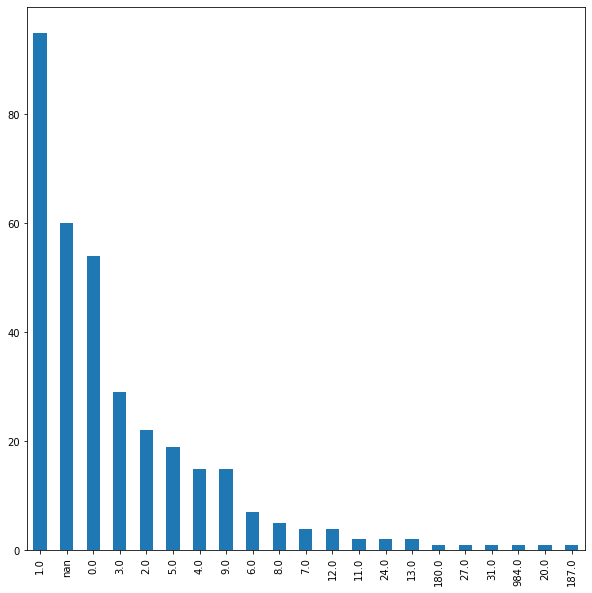

In [32]:
request_dur_freq.plot.bar(figsize=(10,10))

In [33]:
# request_dur_freq.hist(figsize=(10,30), bins=[1,2,3,4,5,6,7,8,9,10,15,20,30,40,50,60,70,80,90,100,150,200])

In [ ]:
request_history_dur_freq = request_history_durations_series.value_counts(dropna=False)
request_history_dur_freq

#### Try Astropy histrograms on large, non-normalized data set

In [36]:
import astropy.visualization as astv, astropy.stats as asts, scipy, numpy as np

In [ ]:
# On all data (request_history_durations_series):
request_history_durs_arr = pd.Series.to_numpy(request_history_durations_series)
print(request_history_durs_arr)
astv.hist(request_history_durs_arr, bins='blocks')

In [ ]:
request_history_freq_arr = pd.Series.to_numpy(request_history_dur_freq)
print(request_history_durs_arr)
astv.hist(request_history_freq_arr, bins='blocks')

In [39]:
# request_history_durations_arr = pd.Series.to_numpy(request_history_durations_series.T)
# print(request_history_durations_arr)
# request_history_time_freq_arr = pd.Series.to_numpy(request_history_time_freq)
# bins = asts.bayesian_blocks(request_history_durations_arr)
count, div = np.histogram(request_history_durations.dropna())
print(div)

[      0.   217848.4  435696.8  653545.2  871393.6 1089242.  1307090.4
 1524938.8 1742787.2 1960635.6 2178484. ]


In [ ]:
request_history_durations.dropna().hist(bins=div, figsize=(20,20))

In [ ]:
request_history_dur_freq.hist(bins="bins", figsize=(20,20))

In [ ]:
request_history_durations.plot.hist(figsize=(20,20), bins=[-1,100,200,20000000])

In [ ]:
request_history_dur_freq.plot.bar(figsize=(20,100))

## Prep data for vizualizing request durations as by occurance time

In [5]:
import matplotlib.pyplot as plt
import numpy as np

#### Get the data

In [6]:
reporting_conn_2 = pyodbc_connect_scotty_test('Interject_Reporting')

In [7]:
# Select [EndTimeStamp] to mark the day, [Duration], from [Request] union with [Request_History] w/ SQL:
from_req = 'SELECT [StartTimeStamp], datediff(second, [StartTimeStamp], [EndTimeStamp]) AS Duration FROM [DataCells].[Request]'
union = ' UNION ALL'
from_req_hist = ' SELECT [StartTimeStamp], datediff(second, [StartTimeStamp], [EndTimeStamp]) AS Duration FROM [DataCells].[Request_History]'
sql = from_req + union + from_req_hist
all_requests = pd.read_sql(sql, reporting_conn_2, index_col='StartTimeStamp')

In [8]:
type(all_requests) is pd.DataFrame

True

#### Initial counts

In [9]:
all_requests.count()

Duration    7698
dtype: int64

In [10]:
all_requests.isna().sum()

Duration    127
dtype: int64

In [11]:
all_requests.isna().sum()

Duration    127
dtype: int64

In [12]:
# Note: Resampler objects are returned by .resample() calls. Will not work until set index to EndTimeStamp!
# dur_by_day_resampler = all_requests_s.resample('D')
# max_dur_by_day_resampler = all_requests_s.resample('D').max()

#### Create basis DFs containing all requests and max daily requests

In [13]:
all_requests['Year'] = all_requests.index.year
all_requests['Month'] = all_requests.index.month
all_requests['Week'] = all_requests.index.week
all_requests['Day'] = all_requests.index.day
all_requests = all_requests.dropna()
all_requests.head()

,Duration,Year,Month,Week,Day
StartTimeStamp,,,,,
2015-05-30 21:23:56.030,0.0,2015,5,22,30
2015-05-30 23:36:55.653,12.0,2015,5,22,30
2015-05-30 23:38:25.200,13.0,2015,5,22,30
2015-05-30 23:44:01.490,9.0,2015,5,22,30
2015-05-30 23:51:05.340,8.0,2015,5,22,30


Create new DataFrame with max request duration for day, + time bucket columns:

In [21]:
# Create daily_max_request DF by downsampling all_requests_df:
daily_max_request = all_requests.resample('D').max()
daily_max_request['Year'] = daily_max_request.index.year
daily_max_request['Month'] = daily_max_request.index.month
daily_max_request['Weekday'] = daily_max_request.index.weekday_name
daily_max_request = daily_max_request.dropna()
daily_max_request = daily_max_request.rename(columns={'Duration':'Max_Duration'})
daily_max_request.head()

# week_groups = daily_max_request.groupby([pd.Grouper(freq='W'), 'Duration'])
# weeks = pd.DataFrame()
# for dur, week in week_groups:
#     week_groups[week.dur] = week.values

# all_requests_df['day'] = all_requests_df.index.day
# all_requests_df['week'] = all_requests_df.index.week

,Max_Duration,Year,Month,Week,Day,Weekday
StartTimeStamp,,,,,,
2015-01-19,4.0,2015,1,4.0,19.0,Monday
2015-01-22,1.0,2015,1,4.0,22.0,Thursday
2015-01-26,46.0,2015,1,5.0,26.0,Monday
2015-01-27,2.0,2015,1,5.0,27.0,Tuesday
2015-01-28,5.0,2015,1,5.0,28.0,Wednesday


In [ ]:
# Create a DF for each month:

def create_df_for_month(origin_df, month_df, month_num): # Can python modify objects passed to it?
    for i in range(len(all_requests_df['Month'])): # 'Month' to be more readable/explicit
        if all_requests['Month'][i] = 1:
            month_df['Month'][i] = 

## Playing around with pure matplotlib...

#### Plot max request durations by day

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x=daily_max_request.Weekday, y=daily_max_request.Duration)
#ax.hist((daily_max_request.weekday))

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(10,10))

# Create the scatter plot for the first week:
ax1.scatter(x=daily_max_request.Weekday, y=daily_max_request.Duration)

In [ ]:
# Use matplotlib object oriented approach to create a plot by day:

# Remove index...

request_days_arr = all_requests_df.day.values # Convert Series to nd array (transpose the matrix first)
print(request_days_arr)
#print(all_requests_arr[0])  # Debugging
# Convert Timestamp data (EndTimeStamp) to datetime:
#for i in range(len(all_requests_arr[0])):
#        all_requests_arr[0][i] = np.datetime64(all_requests_arr[0][i])
       # all_requests_arr[0][i] = np.datetime64(all_requests_arr[0][i])
#print(all_requests_arr[0])  # Debugging

fig, ax = plt.subplots()
ax.hist(all_requests_arr)

In [ ]:
# Check time data types:
print(all_requests_df)
print(durations_by_day)

In [ ]:
weeks = pd.DataFrame()

for day in durations_by_day.count():
    weeks[i] = 


for index, max_dur in durations_by_day:
    weeks[index] = max_dur.values
weeks.plot(subplots=True, legend=False)
plt.show()

## Seaborn for visualizing request durations by time occurred

In [22]:
import seaborn as sns

Add Y, M, W, D columns to all_requests for easy plotting by *occurance time* later. This will be our basis DF for many others.

#### Daily max request durations by weekday

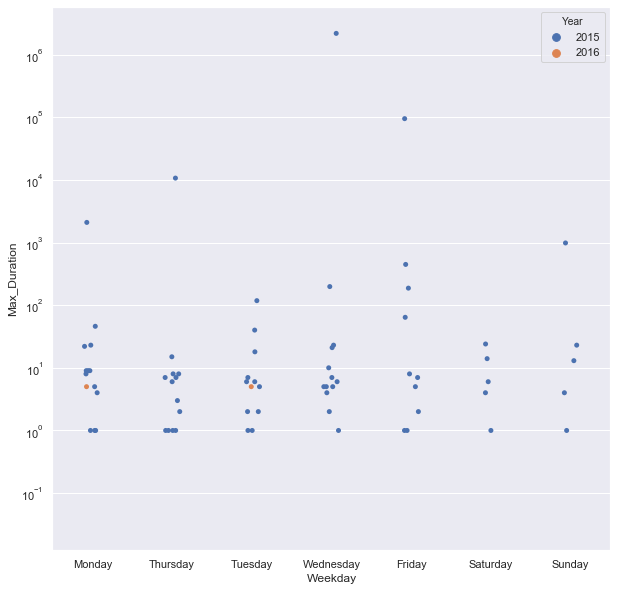

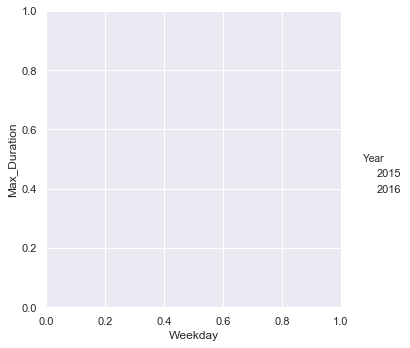

In [191]:
#--- Why do we have two graphs showing up here?
fig, ax = plt.subplots(figsize=(10,10))
ax.set(yscale='log')
sns.catplot(x='Weekday', y='Max_Duration', hue='Year', data=daily_max_request, ax=ax)

# Day of the month instead of week, exclude sat/sun. Should see a pattern of spikes for first 7 day of the month.

# Add another variable, count of durations. Plot with amount of calls, overlay durations.

#### Durations by month

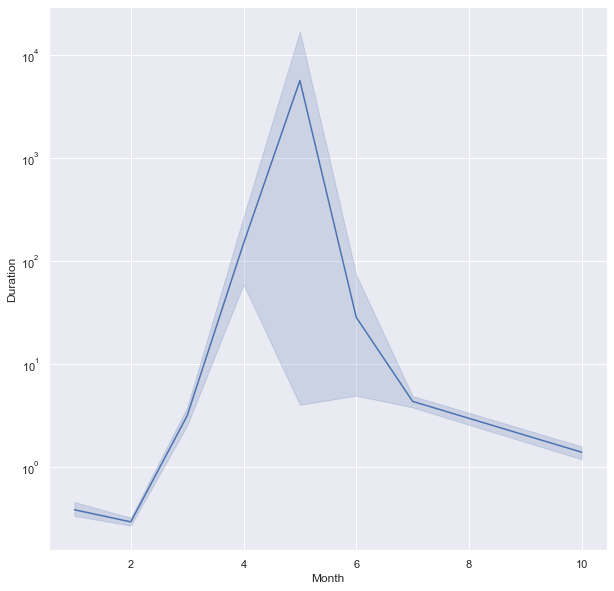

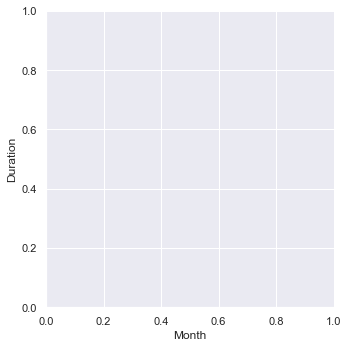

In [165]:
fig_dm, ax_dm = plt.subplots(figsize=(10,10))
sns.set(style='darkgrid')
ax_dm.set(yscale='log')
sns.relplot(x='Month', y='Duration', data=all_requests, ax=ax_dm, kind='line')

#### Create DF for all_requests for each month

Group and split all_requests data by month

In [ ]:
# Hanlde these errors. Handle errors for nulls in all of the code.

In [225]:
grouped_months = all_requests.groupby('Month')
# for name, group in grouped_months:
#     print(name)
#     print(group)

# Some months have no data, exclude these:
all_requests_jan = grouped_months.get_group(1)
all_requests_feb = grouped_months.get_group(2)
all_requests_mar = grouped_months.get_group(3)
all_requests_apr = grouped_months.get_group(4)
all_requests_may = grouped_months.get_group(5)
all_requests_jun = grouped_months.get_group(6)
all_requests_jul = grouped_months.get_group(7)
#all_requests_aug = grouped_months.get_group(8)
# all_requests_sep = grouped_months.get_group(9)
all_requests_oct = grouped_months.get_group(10)
# all_requests_nov = grouped_months.get_group(11)
# all_requests_dec = grouped_months.get_group(12)

#### Durations Jan

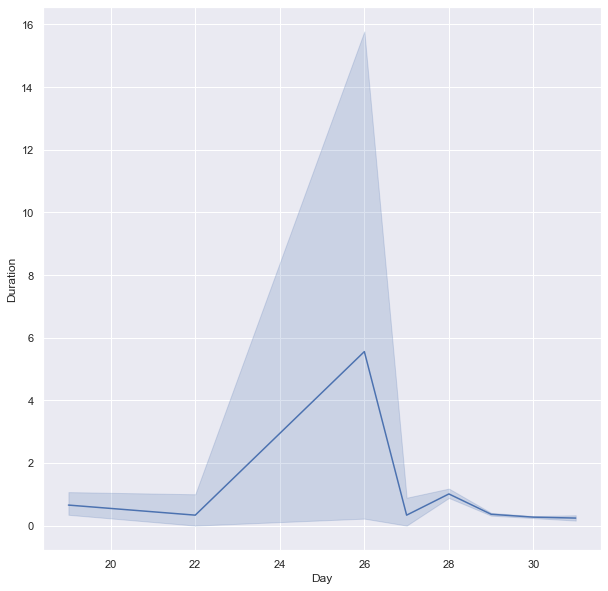

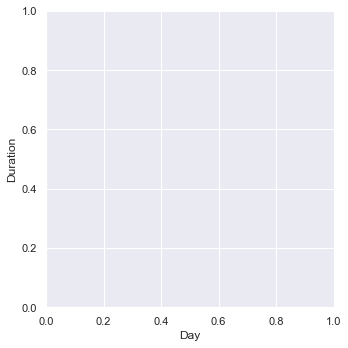

In [105]:
fig_j, ax_j = plt.subplots(figsize=(10,10))
sns.set(style='darkgrid')
sns.relplot(x='Day', y='Duration', data=all_requests_jan, ax=ax_j, kind='line')

#### Durations by day of the month

In [ ]:
# Make labels readable. Exclude weekends. Exclude holidays? Make if very obvious that we are excluding thesedays, make this reversible.

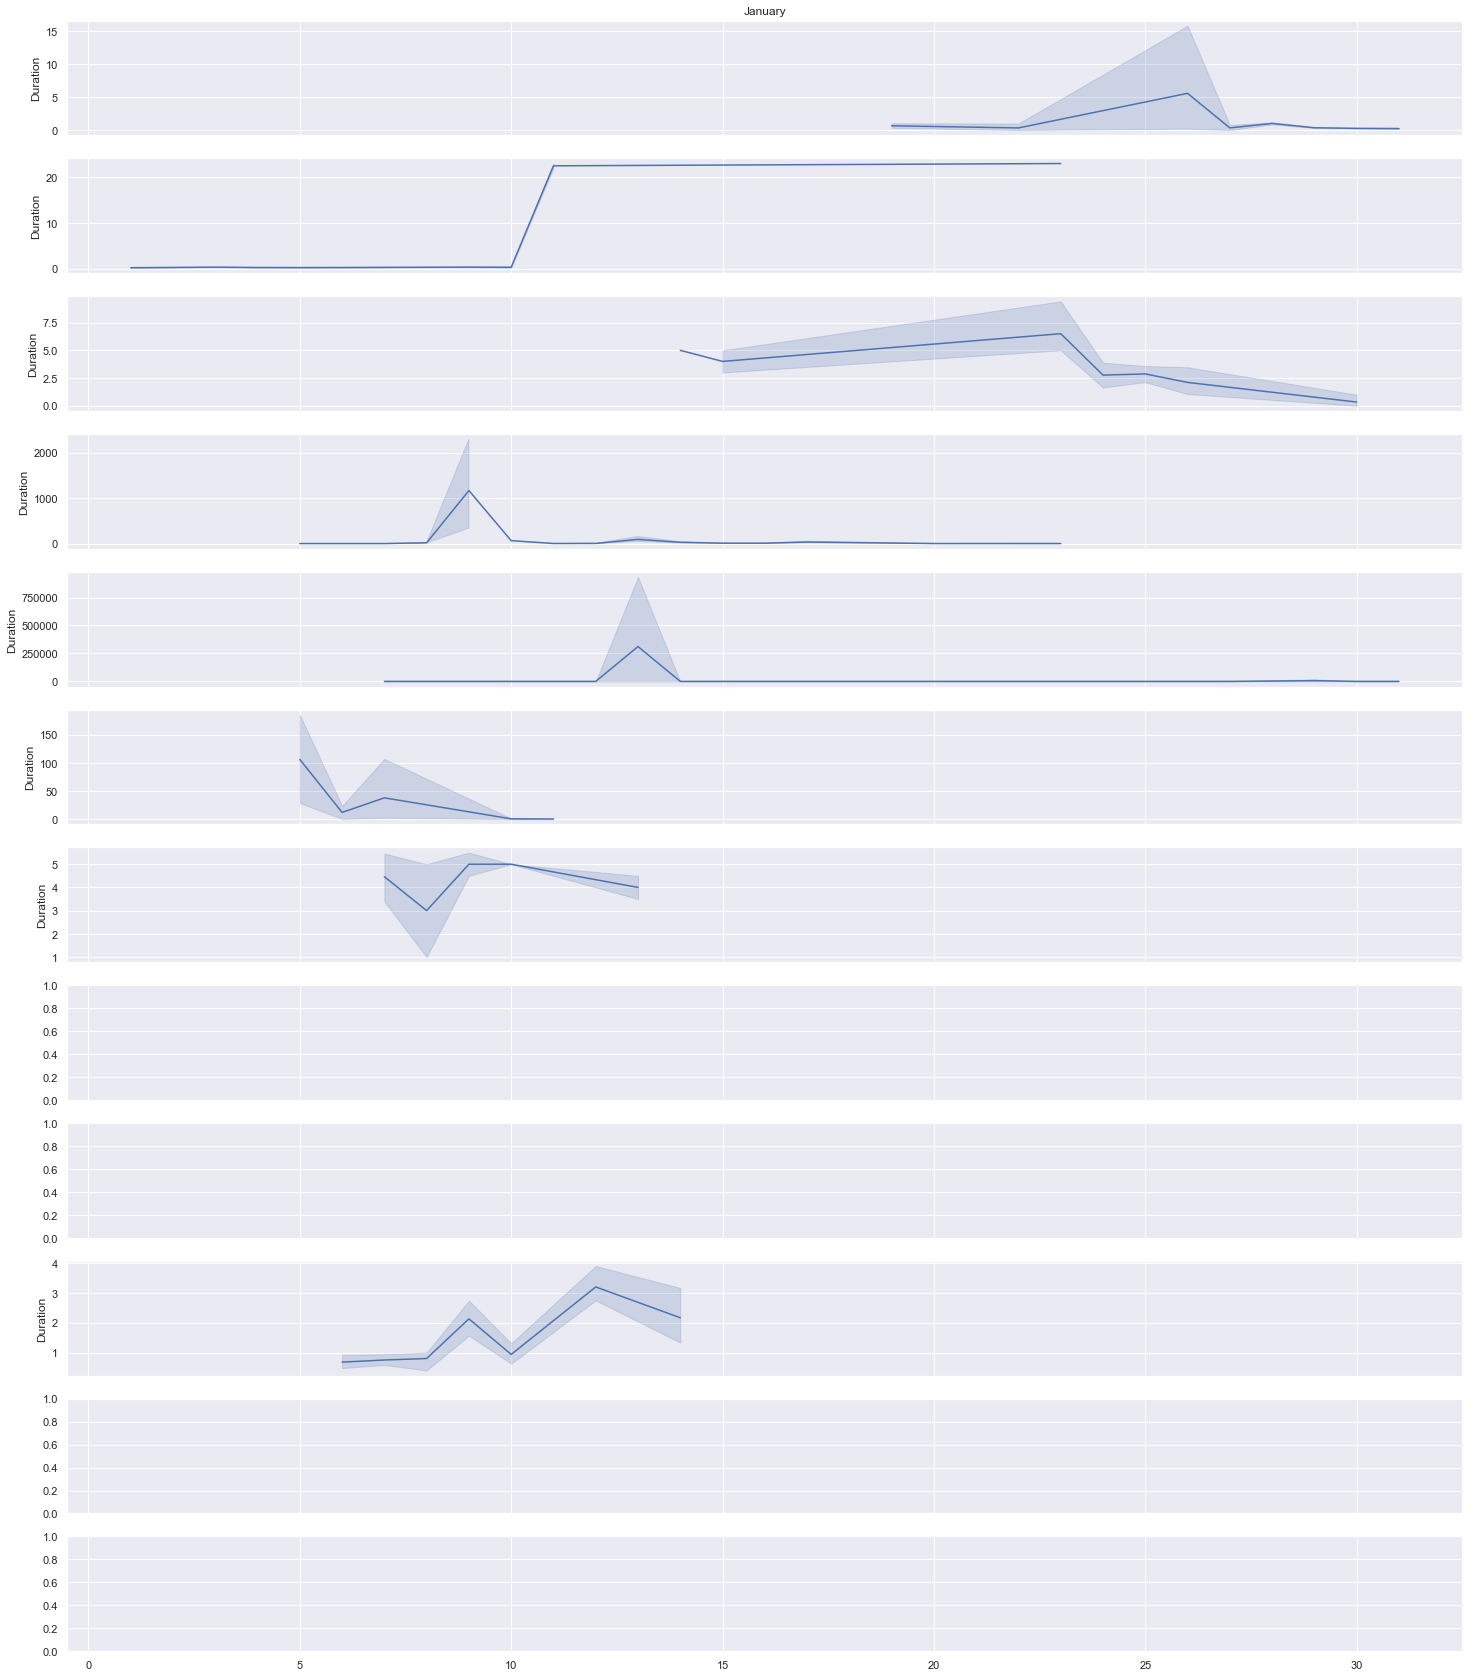

In [226]:
#--- Make this more concise?
fig_months, axes = plt.subplots(12, 1, figsize=(25,30), sharex='all')
sns.lineplot(x='Day', y='Duration', data=all_requests_jan, ax=axes[0]).set(title="January")
sns.lineplot(x='Day', y='Duration', data=all_requests_feb, ax=axes[1])
sns.lineplot(x='Day', y='Duration', data=all_requests_mar, ax=axes[2])
sns.lineplot(x='Day', y='Duration', data=all_requests_apr, ax=axes[3])
sns.lineplot(x='Day', y='Duration', data=all_requests_may, ax=axes[4])
sns.lineplot(x='Day', y='Duration', data=all_requests_jun, ax=axes[5])
sns.lineplot(x='Day', y='Duration', data=all_requests_jul, ax=axes[6])
#sns.lineplot(x='Day', y='Duration', data=all_requests_aug, ax=axes[7])
#sns.lineplot(x='Day', y='Duration', data=all_requests_sep, ax=axes[8])
sns.lineplot(x='Day', y='Duration', data=all_requests_oct, ax=axes[9])
#sns.lineplot(x='Day', y='Duration', data=all_requests_nov, ax=axes[10])
#sns.lineplot(x='Day', y='Duration', data=all_requests_dec, ax=axes[11])`

#### Request load by month

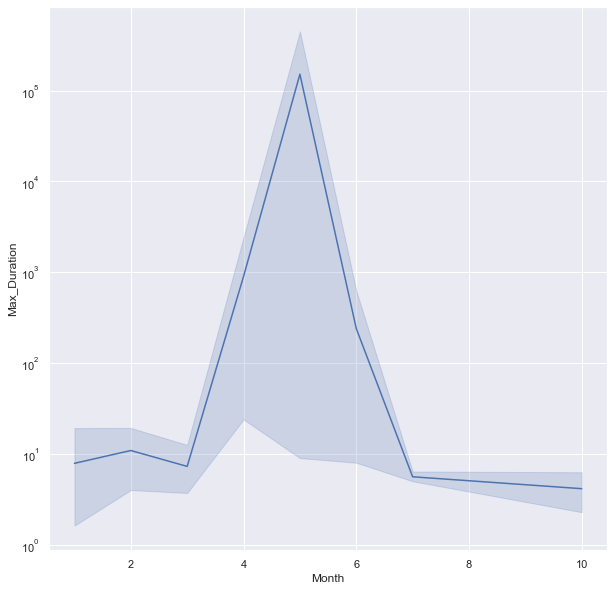

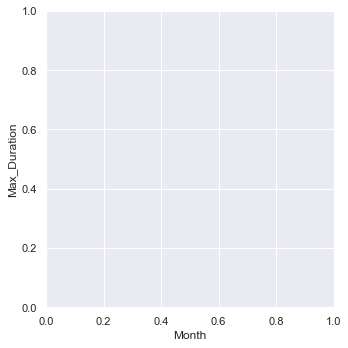

In [166]:
fig_lm, ax_lm = plt.subplots(figsize=(10,10))
sns.set(style='darkgrid')
ax_lm.set(yscale='log')
sns.relplot(x='Month', y='Max_Duration', data=daily_max_request, ax=ax_lm, kind='line')

#### Min/max request dur. per week vs. request load per day

Create new DF with total requests per day:

In [23]:
# Modify this to . Don't necessarily care about days. Collapse into 5 day (M=F) increments and repeat these over each month.
# Summarize average request time but overlay min and max/outliers.
# Use log scale with infinite deviation (for requests so long that something is wrong with the server)/cutoff point for extreme outliers.
# Three months of data for week view. Maybe month-by-month for 2 years. Total health history for all data.
# Make these time variables easy to modify by new users of this notebook.

# We will be giving this to clients. This will be a way to diagnose issues. This notebook will be logs, there wil be another for troubleshooting server issues.

# Might be able to get new data to test (WCN has 5 yrs).

# Prefer mean over average.

In [162]:
daily_request_count = all_requests.resample('D').count()
daily_request_count['Month'] = daily_request_count.index.month
daily_request_count['Weekday'] = daily_request_count.index.weekday_name
daily_request_count = daily_request_count.dropna()
daily_request_count = daily_request_count.rename(columns={'Duration':'Duration_Count'})
daily_request_count.head()

,Duration_Count,Year,Month,Week,Day,Weekday
EndTimeStamp,,,,,,
2015-01-19,29,29,1,29,29,Monday
2015-01-20,0,0,1,0,0,Tuesday
2015-01-21,0,0,1,0,0,Wednesday
2015-01-22,3,3,1,3,3,Thursday
2015-01-23,0,0,1,0,0,Friday


Create DF with maxes/mins per week:

In [216]:
# First get maxes into a new DF with week downsample:
request_max_wk = all_requests.resample('W').max()
#request_max_wk = request_max_wk.rename(columns={'Duration':'Max_Duration'})

# Then get mins into a new DF:
# request_min_wk = all_requests.resample('W').min()
# request_min_wk = request_min_wk.rename(columns={'Duration':'Min_Duration'})

# Create an outliers DF with both max and min:
request_outliers_wk = all_requests.resample('W').min()
request_outliers_wk['Weekday'] = request_outliers_wk.index.weekday_name
request_outliers_wk['Max_Duration'] = request_max_wk['Duration']
request_outliers_wk = request_outliers_wk.rename(columns={'Duration':'Min_Duration'})
request_outliers_wk = request_outliers_wk.dropna()
request_outliers_wk.head()

,Min_Duration,Year,Month,Week,Day,Weekday,Max_Duration
EndTimeStamp,,,,,,,
2015-01-25,0.0,2015.0,1.0,4.0,19.0,Sunday,4.0
2015-02-01,0.0,2015.0,1.0,5.0,1.0,Sunday,46.0
2015-02-08,0.0,2015.0,2.0,6.0,2.0,Sunday,40.0
2015-02-15,0.0,2015.0,2.0,7.0,9.0,Sunday,23.0
2015-03-01,23.0,2015.0,2.0,9.0,23.0,Sunday,23.0
